## **Imports**

### **pip installs**

In [ ]:
!pip install -U albumentations
import albumentations
from albumentations.pytorch import ToTensorV2
!pip install torchgan
import torchgan

     |████████████████████████████████| 98 kB 5.8 MB/s 
     |████████████████████████████████| 37.1 MB 90 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 70 kB 5.6 MB/s 


In [ ]:
!pip install pytorch-gan-metrics
from pytorch_gan_metrics import (get_inception_score_from_directory)


     |████████████████████████████████| 25.9 MB 49.8 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


### **Imports**

In [ ]:
import torch
import json
import skimage
from skimage import io, exposure, img_as_uint, img_as_float
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torchvision.models as models
from scipy import linalg
import time
from torchsummary import summary
import random 
from torch.optim.lr_scheduler import MultiStepLR
from argparse import ArgumentParser
from sklearn.cluster import KMeans
from scipy.stats import norm
import pickle as pkl
import os
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
import torch.nn.functional as F
import math
from torchvision.transforms.transforms import RandomHorizontalFlip, RandomVerticalFlip
import torchvision.transforms as transforms
from skimage import io
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from tqdm.auto import tqdm
from torchvision.utils import make_grid
from torch.nn.utils import spectral_norm
from torch import Tensor
from torch.nn import Parameter
import torch.nn.init as init
import copy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
import matplotlib.gridspec as gridspec
import numbers
import cv2
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
from torch.optim.optimizer import Optimizer, required
from torch.autograd import Variable
from torch import Tensor
from torch.nn import Parameter


# torch.autograd.set_detect_anomaly(False)
# torch.autograd.profiler.profile(False)
# torch.autograd.profiler.emit_nvtx(False)
torch.backends.cudnn.benchmark = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.is_available())

cuda:0
True


## **Data**

In [ ]:
clean_imgs_path ='/content/drive/MyDrive/sim2real_dataset/sim2real_dataset/backgrounds'
clean_imgs_list = os.listdir(clean_imgs_path)
resize_shape = 512 
crop_shape = 512

class CleanDataset():
    def __init__(self,real_dir,real_list, transform = None):

        self.real_list = real_list
        self.real_dir = real_dir
        self.transform = transform

    def __len__(self):
        return len(self.real_list)

    def __getitem__(self, idx):
        real_path = os.path.join(self.real_dir, self.real_list[idx])
        real = io.imread(real_path)
        real = Image.fromarray(real)
        if self.transform:
          real = self.transform(real)
        else:
          real = transforms.ToTensor()(real)

        return real

class ElasticDataset():
    def __init__(self,real_dir,real_list, transform = None):

        self.real_list = real_list
        self.real_dir = real_dir
        self.transform = transform

    def __len__(self):
        return len(self.real_list)

    def __getitem__(self, idx):
        real_path = os.path.join(self.real_dir, self.real_list[idx])
        real = cv2.imread(real_path)
        real = cv2.cvtColor(real, cv2.COLOR_BGR2RGB)
        real = albumentations.Resize(512,512)(image = real)["image"]
        real = albumentations.CenterCrop(512,512)(image = real)["image"]
        real = RandomElastic(alpha = 10,sigma = 0.1)(img = real)
        real = transforms.ToTensor()(real)
        # real = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])(real)
        return real


class FiveCropDataset():
    def __init__(self,real_dir,real_list, transform = None):

        self.real_list = real_list
        self.real_dir = real_dir
        self.transform = transform

    def __len__(self):
        return len(self.real_list)

    def __getitem__(self, idx):
        real_path = os.path.join(self.real_dir, self.real_list[idx])
        real = Image.open(real_path)
        real = real.crop((250, 100, 1700, 1050))
        real = np.array(real.getdata()).reshape((950,1450,3))
        if self.transform:
          real = self.transform(real)
          real = torch.stack(list(real), dim=0)
        return real

clean_transformation = transforms.Compose([
   transforms.Resize(resize_shape),
   transforms.CenterCrop(crop_shape),
   transforms.ToTensor(),
  #  transforms.Normalize(mean=(0,0,0),std=(1,1,1))
])

random_brightness = transforms.Compose([
   transforms.Resize(resize_shape),
   transforms.CenterCrop(crop_shape),
   transforms.ColorJitter(brightness=0.2),
   transforms.ToTensor()
])

random_flips = transforms.Compose([
   transforms.Resize(resize_shape),
   transforms.CenterCrop(crop_shape),
   transforms.RandomHorizontalFlip(p=1),
   transforms.ToTensor()
])


full_imgs_data = CleanDataset(clean_imgs_path,clean_imgs_list,transform = None)


#Clean Dataset
clean_imgs_data = CleanDataset(clean_imgs_path,clean_imgs_list,transform = clean_transformation)
#Random Brightness Dataset
brightness_imgs_data = CleanDataset(clean_imgs_path,clean_imgs_list,transform = random_brightness)
#Random Flips Dataset
flips_imgs_data = CleanDataset(clean_imgs_path,clean_imgs_list,transform = random_flips)
#Elastic Deformation
elastic_imgs_data = ElasticDataset(clean_imgs_path,clean_imgs_list,transform=None)

#Concatenate Datasets and create DataLoader
all_data = ConcatDataset([clean_imgs_data,flips_imgs_data,brightness_imgs_data,elastic_imgs_data])
all_imgs_dataloader = DataLoader(all_data, batch_size=8, shuffle=True,num_workers=0)

all_imgs_dataloader_batch_1 = DataLoader(all_data, batch_size=1, shuffle=True)
# for i in range(40):
#   plt.figure()
#   plt.imshow(brightness_imgs_data[1].permute(1,2,0))
#   plt.axis('off')





# # plt.savefig('/content/drive/MyDrive/Thesis_Material/brightness_img.png', bbox_inches = 'tight')
# plt.show()
# plt.imshow(flips_imgs_data[1].permute(1,2,0))
# plt.axis('off')
# plt.savefig('/content/drive/MyDrive/Thesis_Material/flip_img.png',bbox_inches = 'tight')
# plt.show()

# from google.colab.patches import cv2_imshow
# im_rgb = cv2.cvtColor(clean_imgs_data[1].squeeze(0).permute(1,2,0).detach().cpu().numpy(), cv2.COLOR_BGR2RGB)
# cv2_imshow(255*im_rgb)

## **Useful Functions**

In [ ]:
def show_images(image_tensor, num_images=8):
    #image_tensor = image_tensor*0.5 + 0.5 
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat, nrow=4,padding = 10, pad_value = 1)
    plt.figure()
    plt.imshow(image_grid.permute(1, 2, 0))
    plt.show()


def check_or_create_dir(e,d):
  if e == 0:
    check_directory = os.path.isdir(d)
    if check_directory == False:
      os.makedirs(d)
      print("created folder : ", d)
    else:
      print(d, "folder already exists.")


def plot(loss,cur_epochs,gen_losses,disc_losses,dir):
  if cur_epochs == 0:
    pass
  else:
    if loss != 'wasserstein':
      gen_losses = np.array(gen_losses)
      disc_losses = np.array(disc_losses)

      fig = plt.figure()
      plt.plot(np.arange(len(gen_losses)),gen_losses,label = 'Gen Loss')
      plt.plot(np.arange(len(disc_losses)),disc_losses,label='Disc Loss')
      plt.title('Losses',fontsize = 15)
      plt.xlabel('Epochs',fontsize = 10)
      plt.ylabel('Loss', fontsize = 10)
      plt.legend(prop={'size': 10})
      plt.savefig(f"{dir}/loss.png")
      plt.show()
    else:
      gen_losses = np.array(gen_losses)
      fig = plt.figure()
      plt.plot(np.arange(len(gen_losses)),gen_losses)
      plt.title('Generator Loss',fontsize = 15)
      plt.xlabel('Epochs',fontsize = 10)
      plt.ylabel('Loss', fontsize = 10)
      plt.savefig(f"{dir}/gen_loss.png")
      plt.show()
      disc_losses = np.array(disc_losses)
      fig = plt.figure()
      plt.plot(np.arange(len(disc_losses)),disc_losses)
      plt.title('Discriminator Loss',fontsize = 15)
      plt.xlabel('Epochs',fontsize = 10)
      plt.ylabel('Loss', fontsize = 10)
      plt.savefig(f"{dir}/disc_loss.png")
      plt.show()



def get_noise(n_samples, z_dim, device):
    return torch.randn(n_samples,z_dim,device = device)

def save_gen_images(dir,g_imgs_path, device, cur_epoch, z_dim, gen, num_images=8, size=(3, 512, 512)):

  # if cur_epoch == 0:
  check_directory = os.path.isdir(g_imgs_path)
  if check_directory == False:
    os.makedirs(g_imgs_path)
    print("created folder : ", g_imgs_path)
  else:
    print(g_imgs_path, "folder already exists.")

  gen.eval()

  with torch.no_grad():
    noise = get_noise(num_images,z_dim,device)
    fakes = gen(noise)#[-1]
    imgs = fakes.detach().cpu().view(-1,*size)
    image_grid = make_grid(imgs, nrow=5,padding = 10, pad_value = 1)
    fig = plt.figure(figsize=[50,50])
    plt.imshow(image_grid.permute(1, 2, 0))
    plt.axis('off')
    plt.savefig(f"{g_imgs_path}/gen_imgs_epoch{cur_epoch}.png", bbox_inches = 'tight')
    plt.close(fig)


def init_weights(net, init_type='orthogonal', init_gain=0.02):
    """Initialize network weights.
    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.
    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__ 
        if hasattr(m, 'weight') and classname.find('Conv') != -1:
          if init_type == 'normal':
              init.normal_(m.weight.data, 0.0, init_gain)
          elif init_type == 'xavier':
              init.xavier_normal_(m.weight.data, gain=init_gain)
          elif init_type == 'kaiming':
              init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
          elif init_type == 'orthogonal':
              init.orthogonal_(m.weight.data, gain=init_gain)
          else:
              raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
          if hasattr(m, 'bias') and m.bias is not None:
              init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    net.apply(init_func)



## **Current Device**

In [ ]:
# !nvidia-smi

## **GAN Class**

In [ ]:
class GAN(nn.Module):

    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.gen = generator
        self.disc = discriminator
        self.name = 'GAN'
    
    def get_gen(self):
        return self.gen
    
    def get_disc(self):
        return self.disc

    def name(self):
      return self.name

## **FID (Fretchet Inception Distance)**

In [ ]:
def calculate_FID_score(real_path, fake_path):
        
    def load_images(path):
        
        images_list = os.listdir(path)
        images_list.sort()
        len_dataset = len(images_list)
        dataset = np.zeros([len_dataset, 576, 576, 3])
        for i in range(len_dataset):
           # if i % 10 == 0:
                #print(i)
            dataset[i] = cv2.resize(cv2.imread(os.path.join(path, images_list[i])), (576, 576))
        return dataset

 

    # scale an array of images to a new size
    def scale_images(images, new_shape):
        images_list = list()
        for image in images:
            # resize with nearest neighbor interpolation
            new_image = resize(image, new_shape, 0)
            # store
            images_list.append(new_image)
        return asarray(images_list)
    
    # calculate frechet inception distance
    def calculate_fid(model, images1, images2):
        # calculate activations
        act1 = model.predict(images1)
        act2 = model.predict(images2)
        # calculate mean and covariance statistics
        mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
        mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
        # calculate sum squared difference between means
        ssdiff = np.sum((mu1 - mu2)**2.0)
        # calculate sqrt of product between cov
        covmean = sqrtm(sigma1.dot(sigma2))
        # check and correct imaginary numbers from sqrt
        if iscomplexobj(covmean):
            covmean = covmean.real
        # calculate score
        fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
        return fid

 

    # prepare the inception v3 model
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
    # define two fake collections of images
    images1 = load_images(fake_path)
    images2 = load_images(real_path)
    #print('Prepared', images1.shape, images2.shape)
    # convert integer to floating point values
    images1 = images1.astype('float32')
    images2 = images2.astype('float32')
    # resize images
    images1 = scale_images(images1, (299,299,3))
    images2 = scale_images(images2, (299,299,3))
    #print('Scaled', images1.shape, images2.shape)
    # pre-process images
    images1 = preprocess_input(images1)
    images2 = preprocess_input(images2)

 

    # fid between images1 and images2
    fid = calculate_fid(model, images1, images2)
    # print('FID (different): %.3f' % fid)
    return fid

 


## **Elastic Deformation**

In [ ]:
class RandomElastic(object):
    """Random Elastic transformation by CV2 method on image by alpha, sigma parameter.
        # you can refer to:  https://blog.csdn.net/qq_27261889/article/details/80720359
        # https://blog.csdn.net/maliang_1993/article/details/82020596
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.map_coordinates.html#scipy.ndimage.map_coordinates
    Args:
        alpha (float): alpha value for Elastic transformation, factor
        if alpha is 0, output is original whatever the sigma;
        if alpha is 1, output only depends on sigma parameter;
        if alpha < 1 or > 1, it zoom in or out the sigma's Relevant dx, dy.
        sigma (float): sigma value for Elastic transformation, should be \ in (0.05,0.1)
        mask (PIL Image) if not assign, set None.
    """
    def __init__(self, alpha, sigma):
        assert isinstance(alpha, numbers.Number) and isinstance(sigma, numbers.Number), \
            "alpha and sigma should be a single number."
        assert 0.05 <= sigma <= 0.1, \
            "In pathological image, sigma should be in (0.05,0.1)"
        self.alpha = alpha
        self.sigma = sigma

    @staticmethod
    def RandomElasticCV2(img, alpha, sigma, mask=None):
        alpha = img.shape[1] * alpha
        sigma = img.shape[1] * sigma
        if mask is not None:
            mask = np.array(mask).astype(np.uint8)
            img = np.concatenate((img, mask[..., None]), axis=2)

        shape = img.shape

        dx = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma) * alpha
        dy = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma) * alpha
        # dz = np.zeros_like(dx)

        x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
        indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1)), np.reshape(z, (-1, 1))

        img = map_coordinates(img, indices, order=0, mode='reflect').reshape(shape)
        if mask is not None:
            return Image.fromarray(img[..., :3]), Image.fromarray(img[..., 3])
        else:
            #return Image.fromarray(img)
            return img
    def __call__(self, img, mask=None):
        return self.RandomElasticCV2(np.array(img), self.alpha, self.sigma, mask)

    def __repr__(self):
        format_string = self.__class__.__name__ + '(alpha value={0})'.format(self.alpha)
        format_string += ', sigma={0}'.format(self.sigma)
        format_string += ')'
        return format_string

In [ ]:
# img = clean_imgs_data[17]
# elastic_deformation = RandomElastic(alpha = 15,sigma = 0.1)
# new_img = elastic_deformation(img.permute(1,2,0).numpy())
# #print(new_img)
# plt.imshow(new_img)
# plt.show()
# plt.imshow(img.permute(1,2,0).numpy())
# plt.show()

In [ ]:
# img = cv2.imread(os.path.join(clean_imgs_path,'img_022.png'),cv2.IMREAD_COLOR)
# cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# from google.colab.patches import cv2_imshow

# def draw_grid(im, grid_size):
#     # Draw grid lines
#     for i in range(0, im.shape[1], grid_size):
#         cv2.line(im, (i, 0), (i, im.shape[0]), 	color = (255,255,255), thickness = 2)
#     for j in range(0, im.shape[0], grid_size):
#         cv2.line(im, (0, j), (im.shape[1], j), 	color = (255,255,255), thickness = 2)

# save_dir = '/content/drive/My Drive/Thesis_Material'
# draw_grid(img, 150)
# img_t = transforms.Compose([
#    transforms.Resize(resize_shape),
#    transforms.CenterCrop(crop_shape)])(Image.fromarray(img))
# img_t = np.array(img_t)
# cv2_imshow(img_t)
# cv2.imwrite(os.path.join(save_dir,'example_with_grid_before.png'),img_t)
# elastic_deformation = RandomElastic(alpha = 15,sigma = 0.1)
# new_img = elastic_deformation(img_t)
# cv2_imshow(new_img)
# cv2.imwrite(os.path.join(save_dir,'example_with_grid_after.png'),new_img)

## **Self-Attention Block**

In [ ]:

class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self,in_dim,activation):
        super(Self_Attn,self).__init__()
        self.chanel_in = in_dim
        self.activation = activation
        
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out,attention

## **IMD**

In [ ]:
import scipy.sparse as sps


def _lanczos_m(A, m, nv, rademacher, SV=None):
    '''
    Lanczos algorithm computes symmetric m x m tridiagonal matrix T and matrix V with orthogonal rows
        constituting the basis of the Krylov subspace K_m(A, x),
        where x is an arbitrary starting unit vector.
        This implementation parallelizes `nv` starting vectors.
    
    Arguments:
        m: number of Lanczos steps
        nv: number of random vectors
        rademacher: True to use Rademacher distribution, 
                    False - standard normal for random vectors
        SV: specified starting vectors
    
    Returns:
        T: a nv x m x m tensor, T[i, :, :] is the ith symmetric tridiagonal matrix
        V: a n x m x nv tensor, V[:, :, i] is the ith matrix with orthogonal rows 
    '''
    orthtol = 1e-5
    if type(SV) != np.ndarray:
        if rademacher:
            SV = np.sign(np.random.randn(A.shape[0], nv))
        else:
            SV = np.random.randn(A.shape[0], nv)  # init random vectors in columns: n x nv
    V = np.zeros((SV.shape[0], m, nv))
    T = np.zeros((nv, m, m))

    np.divide(SV, np.linalg.norm(SV, axis=0), out=SV)  # normalize each column
    V[:, 0, :] = SV

    w = A.dot(SV)
    alpha = np.einsum('ij,ij->j', w, SV)
    w -= alpha[None, :] * SV
    beta = np.einsum('ij,ij->j', w, w)
    np.sqrt(beta, beta)

    T[:, 0, 0] = alpha
    T[:, 0, 1] = beta
    T[:, 1, 0] = beta

    np.divide(w, beta[None, :], out=w)
    V[:, 1, :] = w
    t = np.zeros((m, nv))

    for i in range(1, m):
        SVold = V[:, i - 1, :]
        SV = V[:, i, :]

        w = A.dot(SV)  # sparse @ dense
        w -= beta[None, :] * SVold  # n x nv
        np.einsum('ij,ij->j', w, SV, out=alpha)

        T[:, i, i] = alpha

        if i < m - 1:
            w -= alpha[None, :] * SV  # n x nv
            # reortho
            np.einsum('ijk,ik->jk', V, w, out=t)
            w -= np.einsum('ijk,jk->ik', V, t)
            np.einsum('ij,ij->j', w, w, out=beta)
            np.sqrt(beta, beta)
            np.divide(w, beta[None, :], out=w)

            T[:, i, i + 1] = beta
            T[:, i + 1, i] = beta

            # more reotho
            innerprod = np.einsum('ijk,ik->jk', V, w)
            reortho = False
            for _ in range(100):
                if not (innerprod > orthtol).sum():
                    reortho = True
                    break
                np.einsum('ijk,ik->jk', V, w, out=t)
                w -= np.einsum('ijk,jk->ik', V, t)
                np.divide(w, np.linalg.norm(w, axis=0)[None, :], out=w)
                innerprod = np.einsum('ijk,ik->jk', V, w)

            V[:, i + 1, :] = w

            if (np.abs(beta) > 1e-6).sum() == 0 or not reortho:
                break
    return T, V


def _slq(A, m, niters, rademacher):
    '''
    Compute the trace of matrix exponential
    
    Arguments:
        A: square matrix in trace(exp(A))
        m: number of Lanczos steps
        niters: number of quadratures (also, the number of random vectors in the hutchinson trace estimator)
        rademacher: True to use Rademacher distribution, False - standard normal for random vectors in Hutchinson
    Returns:
        trace: estimate of trace of matrix exponential
    '''
    T, _ = _lanczos_m(A, m, niters, rademacher)
    eigvals, eigvecs = np.linalg.eigh(T)
    expeig = np.exp(eigvals)
    sqeigv1 = np.power(eigvecs[:, 0, :], 2)
    trace = A.shape[-1] * (expeig * sqeigv1).sum() / niters
    return trace


def _slq_ts(A, m, niters, ts, rademacher):
    '''
    Compute the trace of matrix exponential
    
    Arguments:
        A: square matrix in trace(exp(-t*A)), where t is temperature
        m: number of Lanczos steps
        niters: number of quadratures (also, the number of random vectors in the hutchinson trace estimator)
        ts: an array with temperatures
        rademacher: True to use Rademacher distribution, False - standard normal for random vectors in Hutchinson
    Returns:
        trace: estimate of trace of matrix exponential across temperatures `ts`
    '''
    T, _ = _lanczos_m(A, m, niters, rademacher)
    eigvals, eigvecs = np.linalg.eigh(T)
    expeig = np.exp(-np.outer(ts, eigvals)).reshape(ts.shape[0], niters, m)
    sqeigv1 = np.power(eigvecs[:, 0, :], 2)
    traces = A.shape[-1] * (expeig * sqeigv1).sum(-1).mean(-1)
    return traces


def _slq_ts_fs(A, m, niters, ts, rademacher, fs):
    '''
    Compute the trace of matrix functions
    
    Arguments:
        A: square matrix in trace(exp(-t*A)), where t is temperature
        m: number of Lanczos steps
        niters: number of quadratures (also, the number of random vectors in the hutchinson trace estimator)
        ts: an array with temperatures
        rademacher: True to use Rademacher distribution, else - standard normal for random vectors in Hutchinson
        fs: a list of functions
    Returns:
        traces: estimate of traces for each of the functions in fs
    '''
    T, _ = _lanczos_m(A, m, niters, rademacher)
    eigvals, eigvecs = np.linalg.eigh(T)
    traces = np.zeros((len(fs), len(ts)))
    for i, f in enumerate(fs):
        expeig = f(-np.outer(ts, eigvals)).reshape(ts.shape[0], niters, m)
        sqeigv1 = np.power(eigvecs[:, 0, :], 2)
        traces[i, :] = A.shape[-1] * (expeig * sqeigv1).sum(-1).mean(-1)
    return traces


def slq_red_var(A, m, niters, ts, rademacher):
    '''
    Compute the trace of matrix exponential with reduced variance
    
    Arguments:
        A: square matrix in trace(exp(-t*A)), where t is temperature
        m: number of Lanczos steps
        niters: number of quadratures (also, the number of random vectors in the hutchinson trace estimator)
        ts: an array with temperatures
    Returns:
        traces: estimate of trace for each temperature value in `ts`
    '''
    fs = [np.exp, lambda x: x]

    traces = _slq_ts_fs(A, m, niters, ts, rademacher, fs)
    subee = traces[0, :] - traces[1, :] / np.exp(ts)
    sub = - ts * A.shape[0] / np.exp(ts)
    return subee + sub


from scipy.sparse import lil_matrix, diags, eye


def np_euc_cdist(data):
    dd = np.sum(data*data, axis=1)
    dist = -2*np.dot(data, data.T)
    dist += dd + dd[:, np.newaxis] 
    np.fill_diagonal(dist, 0)
    np.sqrt(dist, dist)
    return dist


def construct_graph_sparse(data, k):
    n = len(data)
    spmat = lil_matrix((n, n))
    dd = np.sum(data*data, axis=1)
    
    for i in range(n):
        dists = dd - 2*data[i, :].dot(data.T)
        inds = np.argpartition(dists, k+1)[:k+1]
        inds = inds[inds!=i]
        spmat[i, inds] = 1
            
    return spmat.tocsr()


def construct_graph_kgraph(data, k):
    import pykgraph

    n = len(data)
    spmat = lil_matrix((n, n))
    index = pykgraph.KGraph(data, 'euclidean')
    index.build(reverse=0, K=2 * k + 1, L=2 * k + 50)
    result = index.search(data, K=k + 1)[:, 1:]
    spmat[np.repeat(np.arange(n), k, 0), result.ravel()] = 1
    return spmat.tocsr()


def _laplacian_sparse(A, normalized=True):
    D = A.sum(1).A1
    if normalized:
        Dsqrt = diags(1/np.sqrt(D))
        L = eye(A.shape[0]) - Dsqrt.dot(A).dot(Dsqrt)
    else:
        L = diags(D) - A
    return L

import scipy.sparse as sps

EPSILON = 1e-6
NORMALIZATION = 1e6


def _build_graph(data, k=5, graph_builder='sparse', normalized=True):
    """
    Return Laplacian from data or load preconstructed from path
    Arguments:
        data: samples
        k: number of neighbours for graph construction
        graph_builder: if 'kgraph', use faster graph construction
        normalized: if True, use nnormalized Laplacian
    Returns:
        L: Laplacian of the graph constructed with data
    """
    if graph_builder == 'sparse':
        A = construct_graph_sparse(data, k)
    elif graph_builder == 'kgraph':
        A = construct_graph_kgraph(data, k)
    else:
        raise Exception('Please specify graph builder: sparse or kgraph.')
    A = (A + A.T) / 2
    A.data = np.ones(A.data.shape)
    L = _laplacian_sparse(A, normalized)
    return L


def _normalize_msid(msid, normalization, n, k, ts):
    normed_msid = msid.copy()
    if normalization == 'empty':
        normed_msid /= n
    elif normalization == 'complete':
        normed_msid /= (1 + (n - 1) * np.exp(-(1 + 1 / (n - 1)) * ts))
    elif normalization == 'er':
        xs = np.linspace(0, 1, n)
        er_spectrum = 4 / np.sqrt(k) * xs + 1 - 2 / np.sqrt(k)
        er_msid = np.exp(-np.outer(ts, er_spectrum)).sum(-1)
        normed_msid = normed_msid / (er_msid + EPSILON)
    elif normalization == 'none' or normalization is None:
        pass
    else:
        raise ValueError('Unknown normalization parameter!')
    return normed_msid


def msid_score(x, y, ts=np.logspace(-1, 1, 256), k=5, m=10, niters=100, rademacher=False, graph_builder='sparse',
              msid_mode='max', normalized_laplacian=True, normalize='empty'):
    '''
    Compute the msid score between two samples, x and y
    Arguments:
        x: x samples
        y: y samples
        ts: temperature values
        k: number of neighbours for graph construction
        m: Lanczos steps in SLQ
        niters: number of starting random vectors for SLQ
        rademacher: if True, sample random vectors from Rademacher distributions, else sample standard normal distribution
        graph_builder: if 'kgraph', uses faster graph construction (options: 'sparse', 'kgraph')
        msid_mode: 'l2' to compute the l2 norm of the distance between `msid1` and `msid2`;
                'max' to find the maximum abosulute difference between two descriptors over temperature
        normalized_laplacian: if True, use normalized Laplacian
        normalize: 'empty' for average heat kernel (corresponds to the empty graph normalization of NetLSD),
                'complete' for the complete, 'er' for erdos-renyi
                normalization, 'none' for no normalization
    Returns:
        msid_score: the scalar value of the distance between discriptors
    '''
    normed_msidx = msid_descriptor(x, ts, k, m, niters, rademacher, graph_builder, normalized_laplacian, normalize)
    normed_msidy = msid_descriptor(y, ts, k, m, niters, rademacher, graph_builder, normalized_laplacian, normalize)

    c = np.exp(-2 * (ts + 1 / ts))

    if msid_mode == 'l2':
        score = np.linalg.norm(normed_msidx - normed_msidy)
    elif msid_mode == 'max':
        score = np.amax(c * np.abs(normed_msidx - normed_msidy))
    else:
        raise Exception('Use either l2 or max mode.')

    return score


def msid_descriptor(x, ts=np.logspace(-1, 1, 256), k=5, m=10, niters=100, rademacher=False, graph_builder='sparse',
              normalized_laplacian=True, normalize='empty'):
    '''
    Compute the msid descriptor for a single sample x
    Arguments:
        x: x samples
        ts: temperature values
        k: number of neighbours for graph construction
        m: Lanczos steps in SLQ
        niters: number of starting random vectors for SLQ
        rademacher: if True, sample random vectors from Rademacher distributions, else sample standard normal distribution
        graph_builder: if 'kgraph', uses faster graph construction (options: 'sparse', 'kgraph')
        normalized_laplacian: if True, use normalized Laplacian
        normalize: 'empty' for average heat kernel (corresponds to the empty graph normalization of NetLSD),
                'complete' for the complete, 'er' for erdos-renyi
                normalization, 'none' for no normalization
    Returns:
        normed_msidx: normalized msid descriptor
    '''
    Lx = _build_graph(x, k, graph_builder, normalized_laplacian)

    nx = Lx.shape[0]
    msidx = slq_red_var(Lx, m, niters, ts, rademacher)

    normed_msidx = _normalize_msid(msidx, normalize, nx, k, ts) * NORMALIZATION

    return normed_msidx

# **DC Generator**

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz, ngf = 16, nc = 3):
        super(Generator, self).__init__()

        self.nc = nc
        self.nz = nz
        self.ngf = ngf

        self.leaky = nn.LeakyReLU(0.2)

        self.deconv1 = nn.ConvTranspose2d(self.nz, self.ngf * 16, 4, 2, 1)
        self.batchnorm1 = nn.BatchNorm2d(self.ngf*16)
        self.deconv2 = nn.ConvTranspose2d(self.ngf * 16,  self.ngf * 8, 4, 2, 1)
        self.batchnorm2 = nn.BatchNorm2d(self.ngf*8)
        self.deconv3 = nn.ConvTranspose2d(self.ngf * 8,  self.ngf * 8, 4, 2, 1)
        self.batchnorm3 = nn.BatchNorm2d(self.ngf*8)
        self.deconv4 = nn.ConvTranspose2d(self.ngf * 8,  self.ngf * 8, 4, 2, 1)
        self.batchnorm4 = nn.BatchNorm2d(self.ngf*8)
        self.deconv5 = nn.ConvTranspose2d(self.ngf * 8,  self.ngf * 4, 4, 2, 1)
        self.batchnorm5 = nn.BatchNorm2d(self.ngf*4)
        self.deconv6 = nn.ConvTranspose2d(self.ngf * 4,  self.ngf * 4, 4, 2, 1)
        self.batchnorm6 = nn.BatchNorm2d(self.ngf*4)
        self.deconv7 = nn.ConvTranspose2d(self.ngf * 4,  self.ngf * 4, 4, 2, 1)
        self.batchnorm7 = nn.BatchNorm2d(self.ngf*4)
        self.deconv8 = nn.ConvTranspose2d(self.ngf * 4,  self.ngf * 4, 4, 2, 1)
        self.batchnorm8 = nn.BatchNorm2d(self.ngf*4)
        self.deconv9 = nn.ConvTranspose2d(self.ngf * 4,  self.nc,   4, 2, 1)
        self.tanh = nn.Tanh()

    def forward(self, input):

        input = input.view(len(input), self.nz, 1, 1)

        output = self.deconv1(input)
        output = self.batchnorm1(output)
        output = self.leaky(output)

        output = self.deconv2(output)
        output = self.batchnorm2(output)
        output = self.leaky(output)

        output = self.deconv3(output)
        output = self.batchnorm3(output)
        output = self.leaky(output)

        output = self.deconv4(output)
        output = self.batchnorm4(output)
        output = self.leaky(output)

        output = self.deconv5(output)
        output = self.batchnorm5(output)
        output = self.leaky(output)

        output = self.deconv6(output)
        output = self.batchnorm6(output)
        output = self.leaky(output)


        output = self.deconv7(output)
        output = self.batchnorm7(output)
        output = self.leaky(output)

        output = self.deconv8(output)
        output = self.batchnorm8(output)
        output = self.leaky(output)

        output = self.deconv9(output)
        output = self.tanh(output)

        return output

    def get_name(self):
      return 'DC Generator'

# **DC Discriminator**

In [ ]:
class Discriminator(nn.Module):
    # initializers
    def __init__(self, d=64):

        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv1_in = nn.BatchNorm2d(d)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_in = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_in = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 2, 1)
        self.conv4_in = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, 1, 3, 1, 1)
        self.leaky = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()
    # forward method
    def forward(self, input):
        x = input
        x = self.leaky(self.conv1(x))
        x = self.leaky(self.conv2_in(self.conv2(x)))
        x = self.leaky(self.conv3_in(self.conv3(x)))
        x = self.leaky(self.conv4_in(self.conv4(x)))
        x = self.conv5(x)
        x = self.sigmoid(x)
        return x
        
    def get_name(self):
      return 'DC Discriminator'

# **Discriminator with Spectral Normalization**

In [ ]:
class SNDiscriminator(nn.Module):
    def __init__(self,d = 64):
        super(SNDiscriminator,self).__init__()

        self.conv2d_1 = spectral_norm(nn.Conv2d(3,d,4,2,1))
        self.conv2d_2 = spectral_norm(nn.Conv2d(d,d*2, 4,2,1))
        self.batchnorm2 = nn.BatchNorm2d(d*2)
        self.conv2d_3 = spectral_norm(nn.Conv2d(d*2,d*4, 4,2,1))
        self.batchnorm3 = nn.BatchNorm2d(d*4)
        self.conv2d_4 = spectral_norm(nn.Conv2d(d*4,d*8, 4,2,1))
        self.batchnorm4 = nn.BatchNorm2d(d*8)
        self.conv2d_5 = spectral_norm(nn.Conv2d(d*8,d*8,4,2,1))
        self.batchnorm5 = nn.BatchNorm2d(d*8)
        self.conv2d_6 = spectral_norm(nn.Conv2d(d*8,1,3,1,1))

        self.sigmoid = nn.Sigmoid()
        self.leaky = nn.LeakyReLU(0.2)
    def forward(self, x):
      
        x = self.leaky(self.conv2d_1(x))
        x = self.leaky(self.batchnorm2(self.conv2d_2(x)))
        x = self.leaky(self.batchnorm3(self.conv2d_3(x)))
        x = self.leaky(self.batchnorm4(self.conv2d_4(x)))
        x = self.leaky(self.batchnorm5(self.conv2d_5(x)))
        x = self.sigmoid(self.conv2d_6(x))

        return x
    def get_name(self):
      return 'Spectral Normalization Discriminator'

# **Self Attention Generator**

In [ ]:
class SAGenerator(nn.Module):
    def __init__(self, nz, ngf =16, nc = 3):
        super(SAGenerator, self).__init__()

        self.nc = nc
        self.nz = nz
        self.ngf = ngf

        self.attn1 = Self_Attn(ngf*4,'leakyrelu')
        self.leaky = nn.LeakyReLU(0.2)
        
        self.deconv1 = (nn.ConvTranspose2d(self.nz, self.ngf * 16, 4, 2, 1))
        self.batchnorm1 = nn.BatchNorm2d(self.ngf*16)
        self.deconv2 = (nn.ConvTranspose2d(self.ngf * 16,  self.ngf * 8, 4, 2, 1))
        self.batchnorm2 = nn.BatchNorm2d(self.ngf*8)
        self.deconv3 = (nn.ConvTranspose2d(self.ngf * 8,  self.ngf * 8, 4, 2, 1))
        self.batchnorm3 = nn.BatchNorm2d(self.ngf*8)
        self.deconv4 = (nn.ConvTranspose2d(self.ngf * 8,  self.ngf * 8, 4, 2, 1))
        self.batchnorm4 = nn.BatchNorm2d(self.ngf*8)
        self.deconv5 = (nn.ConvTranspose2d(self.ngf * 8,  self.ngf * 4, 4, 2, 1))
        self.batchnorm5 = nn.BatchNorm2d(self.ngf*4)
        self.deconv6 = (nn.ConvTranspose2d(self.ngf * 4,  self.ngf * 4, 4, 2, 1))
        self.batchnorm6 = nn.BatchNorm2d(self.ngf*4)
        self.deconv7 = (nn.ConvTranspose2d(self.ngf * 4,  self.ngf * 4, 4, 2, 1))
        self.batchnorm7 = nn.BatchNorm2d(self.ngf*4)
        self.deconv8 = (nn.ConvTranspose2d(self.ngf * 4,  self.ngf * 4, 4, 2, 1))
        self.batchnorm8 = nn.BatchNorm2d(self.ngf*4)
        self.deconv9 = (nn.ConvTranspose2d(self.ngf * 4,  self.nc,   4, 2, 1))
        self.tanh = nn.Tanh()

    def forward(self, input):

        input = input.view(len(input), self.nz, 1, 1)

        output = self.deconv1(input)
        output = self.batchnorm1(output)
        output = self.leaky(output)

        output = self.deconv2(output)
        output = self.batchnorm2(output)
        output = self.leaky(output)

        output = self.deconv3(output)
        output = self.batchnorm3(output)
        output = self.leaky(output)

        output = self.deconv4(output)
        output = self.batchnorm4(output)
        output = self.leaky(output)


        output = self.deconv5(output)
        output = self.batchnorm5(output)
        output = self.leaky(output)

        output = self.deconv6(output)
        output = self.batchnorm6(output)
        output = self.leaky(output)

        output,_ = self.attn1(output)

        output = self.deconv7(output)
        output = self.batchnorm7(output)
        output = self.leaky(output)


        output = self.deconv8(output)
        output = self.batchnorm8(output)
        output = self.leaky(output)


        output = self.deconv9(output)
        output = self.tanh(output)

        return output
    
    def get_name(self):
      return 'Self Attention Generator with Spectral Normalization'

# **Critic with Spectral Normalization**

In [ ]:
class SpectralCritic(nn.Module):
    def __init__(self,d = 64):
        super(SpectralCritic,self).__init__()

        self.conv2d_1 = spectral_norm(nn.Conv2d(3,d,4,2,1))
        self.conv2d_2 = spectral_norm(nn.Conv2d(d,d*2, 4,2,1))
        self.batchnorm2 = nn.BatchNorm2d(d*2)
        self.conv2d_3 = spectral_norm(nn.Conv2d(d*2,d*4, 4,2,1))
        self.batchnorm3 = nn.BatchNorm2d(d*4)
        self.conv2d_4 = spectral_norm(nn.Conv2d(d*4,d*8, 4,2,1))
        self.batchnorm4 = nn.BatchNorm2d(d*8)
        self.conv2d_5 = spectral_norm(nn.Conv2d(d*8,d*8,4,2,1))
        self.batchnorm5 = nn.BatchNorm2d(d*8)
        self.conv2d_6 = spectral_norm(nn.Conv2d(d*8,1,3,1,1))

        self.sigmoid = nn.Sigmoid()
        self.leaky = nn.LeakyReLU(0.2)
    def forward(self, x):
      
        x = self.leaky(self.conv2d_1(x))
        x = self.leaky(self.batchnorm2(self.conv2d_2(x)))
        x = self.leaky(self.batchnorm3(self.conv2d_3(x)))
        x = self.leaky(self.batchnorm4(self.conv2d_4(x)))
        x = self.leaky(self.batchnorm5(self.conv2d_5(x)))
        x = self.conv2d_6(x)

        return x
    def get_name(self):
      return 'Spectral Normalization Critic'

# **Critic**

In [ ]:
class Critic(nn.Module):
    def __init__(self,d = 64):
        super(Critic,self).__init__()

        self.conv2d_1 = nn.Conv2d(3,d,4,2,1)
        self.conv2d_2 = nn.Conv2d(d,d*2, 4,2,1)
        self.batchnorm2 = nn.BatchNorm2d(d*2)
        self.conv2d_3 = nn.Conv2d(d*2,d*4, 4,2,1)
        self.batchnorm3 = nn.BatchNorm2d(d*4)
        self.conv2d_4 = nn.Conv2d(d*4,d*8, 4,2,1)
        self.batchnorm4 = nn.BatchNorm2d(d*8)
        self.conv2d_5 = nn.Conv2d(d*8,d*8,4,2,1)
        self.batchnorm5 = nn.BatchNorm2d(d*8)
        self.conv2d_6 = nn.Conv2d(d*8,1,3,1,1)

        self.sigmoid = nn.Sigmoid()
        self.leaky = nn.LeakyReLU(0.2)
    def forward(self, x):
      
        x = self.leaky(self.conv2d_1(x))
        x = self.leaky(self.batchnorm2(self.conv2d_2(x)))
        x = self.leaky(self.batchnorm3(self.conv2d_3(x)))
        x = self.leaky(self.batchnorm4(self.conv2d_4(x)))
        x = self.leaky(self.batchnorm5(self.conv2d_5(x)))
        x = self.conv2d_6(x)

        return x
    def get_name(self):
      return 'Critic'

# **Loss Function**

In [ ]:
def calculate_disc_loss(loss_type,smooth_labels,cur_batch_size,real,fake,d,fake_prediction_labels,real_prediction_labels,device):
  real_label = 0.9
  fake_label = 0.1
  if loss_type == 'mse':
    if smooth_labels:
      real_loss = nn.MSELoss()(real_prediction_labels,torch.full(real_prediction_labels.shape, real_label, device=device))
      fake_loss = nn.MSELoss()(fake_prediction_labels,torch.full(fake_prediction_labels.shape, fake_label, device=device))
    else:
      real_loss = nn.MSELoss()(real_prediction_labels,torch.ones_like(real_prediction_labels))
      fake_loss = nn.MSELoss()(fake_prediction_labels,torch.zeros_like(fake_prediction_labels))
    loss = real_loss + fake_loss

  elif loss_type == 'wasserstein':

    epsilon = torch.rand(cur_batch_size, 1, 1, 1, device=device, requires_grad=True)
    mixed_images = real * epsilon + fake.detach() * (1 - epsilon)
    mixed_scores = d(mixed_images)

    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]

    gradient_penalty = ((gradient.view(len(gradient), -1).norm(2, dim=1)-1)**2).mean()
    loss = torch.mean(fake_prediction_labels) - torch.mean(real_prediction_labels) + 10.0*gradient_penalty
  
  return loss

def calculate_gen_loss(loss_type,smooth_labels, fake_prediction_labels,lambda_weight,fake,real):
  real_label = 0.9
  if loss_type == 'mse':
    if smooth_labels:
      loss = nn.MSELoss()(fake_prediction_labels,torch.full(fake_prediction_labels.shape, real_label, device=device)) + lambda_weight*nn.L1Loss()(fake,real)
    else:
      loss = nn.MSELoss()(fake_prediction_labels,torch.ones_like(fake_prediction_labels)) + lambda_weight*nn.L1Loss()(fake,real)

  elif loss_type == 'wasserstein':
    loss = -torch.mean(fake_prediction_labels) + lambda_weight*nn.L1Loss()(fake,real)
 
  return loss

# **Train GAN**

In [ ]:
def train_gan(generator, discriminator, data, dir, imgs_path, loss, n_epochs, disc_lr, gen_lr, z_dim, lambda_weight , smooth_labels):
  generator.to(device)
  discriminator.to(device)

  init_weights(generator)
  init_weights(discriminator)
  
  n_batches = len(data)
  num_of_params_g = sum(p.numel() for p in generator.parameters() if p.requires_grad)
  num_of_params_d = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)

  num_of_params = num_of_params_d+num_of_params_g

  print('Shape of the generated image: ({},{})'.format(512,512))

  gen_opt = torch.optim.AdamW(generator.parameters(),lr=gen_lr,betas =(0.5,0.99))
  disc_opt = torch.optim.AdamW(discriminator.parameters(),lr=disc_lr,betas =(0.5,0.99))
  g_scheduler = MultiStepLR(gen_opt,milestones = [100,200])
  d_scheduler = MultiStepLR(disc_opt,milestones = [100,200]) 

  loss_dict = {'Epoch': [],
              'Generator Loss': [],
              'Discriminator Loss': [],
              }


  param_dict = {'Generator': [generator.get_name()],
                'Discriminator': [discriminator.get_name()],
                'Batch Size': [data.batch_size],
                'Noise Dimension': [z_dim],
                'Loss Function': [loss],
                'Label Smoothing': [smooth_labels],
                'L1 weight': [lambda_weight],
                'Generator Learning Rate': [gen_lr],
                'Disriminator Learning Rate': [disc_lr],
                'Training Time': [0],
                'Model Parameters': [num_of_params]
                  }
  
  check_or_create_dir(0, dir)

  training_start = time.time()
  for epoch in range(n_epochs):
    generator.train()
    discriminator.train()
    #Initialize losses
    g_loss = 0
    d_loss = 0
    for real in tqdm(data):
      real = real.float().to(device)
      cur_batch_size = len(real)
      #Discriminator
      disc_opt.zero_grad()
      real_data= 0.9*real+0.1*torch.randn((real.size()), device=device)
      real_prediction_labels = discriminator(real_data)
      noise = get_noise(cur_batch_size, z_dim,device)
      fake_generated = generator(noise)
      fake_data = 0.9*fake_generated.detach()+0.1*torch.randn((fake_generated.size()), device=device)
      fake_prediction_labels = discriminator(fake_data.detach())
      disc_loss = calculate_disc_loss(loss,smooth_labels,cur_batch_size,real,fake_generated,discriminator,fake_prediction_labels,real_prediction_labels,device)
      disc_loss.backward()
      disc_opt.step()
      d_scheduler.step()

      ####Generator####
      gen_opt.zero_grad()
      fake_generated = generator(get_noise(cur_batch_size, z_dim,device))
      fake_data = 0.9*fake_generated+0.1*torch.randn((fake_generated.size()), device=device)
      fake_prediction_labels = discriminator(fake_data)
      gen_loss = calculate_gen_loss(loss,smooth_labels,fake_prediction_labels,lambda_weight,fake_generated,real)
      gen_loss.backward()
      gen_opt.step()
      g_scheduler.step()

      g_loss += gen_loss
      d_loss += disc_loss

    g_loss = g_loss/n_batches
    d_loss = d_loss/n_batches

    loss_dict['Epoch'].append(epoch) 
    loss_dict['Generator Loss'].append(g_loss.item()) 
    loss_dict['Discriminator Loss'].append(d_loss.item())

    print(f"Epoch: {epoch} Gen Loss: {g_loss.item()} Disc Loss: {d_loss.item()}")

    if epoch % 10 == 0:


    ####Save the Generator model/parameters/generated images####
    
    if epoch % 10 == 0:
      torch.save(generator., os.path.join(dir,f'generator_{epoch}.pth'))
      torch.save(discriminator,os.path.join(dir,f'discriminator_{epoch}.pth'))
      plot(loss,epoch,loss_dict['Generator Loss'],loss_dict['Discriminator Loss'],dir)
      show_images(real)
      show_images(fake_generated)
    save_gen_images(dir, imgs_path, device, epoch, z_dim, generator, num_images=25, size=(3, 512, 512))

  training_stop = time.time()
  param_dict['Training Time'] = (training_stop-training_start)
  losses_pd = pd.DataFrame.from_dict(loss_dict) 
  losses_pd.to_csv(os.path.join(dir,'losses_history.csv'))
  param_pd = pd.DataFrame.from_dict(param_dict)
  param_pd.to_csv(os.path.join(dir,'parameters.csv'))

# **Train WGAN**

In [ ]:
def train_wgan(generator, discriminator, data,all_data, dir, imgs_path, loss, n_epochs, disc_lr, gen_lr, z_dim, lambda_weight , smooth_labels,d_repeats):
  init_weights(generator)
  init_weights(discriminator)
  
  model = GAN(generator,discriminator).to(device)
  num_of_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print('Shape of the generated image: ({},{})'.format(512,512))
  n_batches = len(data)

  gen_lr  = 0.00005
  disc_lr = 0.00005

  gen_opt = torch.optim.RMSprop(model.gen.parameters(),lr=gen_lr)
  disc_opt = torch.optim.RMSprop(model.disc.parameters(),lr=disc_lr)
  g_scheduler = MultiStepLR(gen_opt,milestones = [100,199])
  d_scheduler = MultiStepLR(disc_opt,milestones = [100,199])

  loss_dict = {'Epoch': [],
              'Generator Loss': [],
              'Discriminator Loss': [],
              }

  param_dict = {'Generator': [model.gen.get_name()],
                'Discriminator': [model.disc.get_name()],
                'Discriminator Repeats': [d_repeats],
                'Batch Size': [all_imgs_dataloader.batch_size],
                'Noise Dimension': [z_dim],
                'Loss Function': [loss_type],
                'Label Smoothing': [smooth_labels],
                'L1 weight': [lambda_weight],
                'Generator Learning Rate': [gen_lr],
                'Disriminator Learning Rate': [disc_lr],
                'Training Time': [0],
                'Model Parameters': [num_of_params]
                  }

  check_or_create_dir(0, dir)


  
  training_start = time.time()
  for epoch in range(n_epochs):
    model.train()
    g_loss = 0
    d_loss = 0
    for real in tqdm(data):
      real = real.float().to(device)
      cur_batch_size = len(real)
      #Discriminator
      loss_disc_iter = 0
      for repeat in range(d_repeats):
        disc_opt.zero_grad()
        real_data= 0.9*real+0.1*torch.randn((real.size()), device=device)
        real_prediction_labels = model.disc(real_data)
        noise = get_noise(cur_batch_size, z_dim,device)
        fake_generated = model.gen(noise)
        fake_data = 0.9*fake_generated.detach()+0.1*torch.randn((fake_generated.size()), device=device)
        fake_prediction_labels = model.disc(fake_data.detach())
        disc_loss = calculate_disc_loss(loss,smooth_labels,cur_batch_size,real,fake_generated,model.disc,fake_prediction_labels,real_prediction_labels,device)
        disc_loss.backward()
        disc_opt.step()
        d_scheduler.step()
        loss_disc_iter += disc_loss/d_repeats
      disc_loss = loss_disc_iter

      ####Generator####
      gen_opt.zero_grad()
      fake_generated = model.gen(get_noise(cur_batch_size, z_dim,device))
      fake_data = 0.9*fake_generated+0.1*torch.randn((fake_generated.size()), device=device)
      fake_prediction_labels = model.disc(fake_data)
      gen_loss = calculate_gen_loss(loss,smooth_labels,fake_prediction_labels,lambda_weight,fake_generated,real)
      gen_loss.backward()
      gen_opt.step()
      g_scheduler.step()

      g_loss += gen_loss
      d_loss += disc_loss

    g_loss = g_loss/n_batches
    d_loss = d_loss/n_batches

    loss_dict['Epoch'].append(epoch) 
    loss_dict['Generator Loss'].append(g_loss.item()) 
    loss_dict['Discriminator Loss'].append(d_loss.item())

    print(f"Epoch: {epoch} Gen Loss: {g_loss.item()} Disc Loss: {d_loss.item()}")

    ####Save the Generator model/parameters/generated images####
    
    if epoch % 10 == 0:
      plot(loss_type,epoch,loss_dict['Generator Loss'],loss_dict['Discriminator Loss'],dir)
      torch.save(model.gen, os.path.join(dir,f'generator_{epoch}.pth'))
      torch.save(model.disc,os.path.join(dir,f'discriminator_{epoch}.pth'))
      plot(loss,epoch,loss_dict['Generator Loss'],loss_dict['Discriminator Loss'],dir)
      show_images(real)
      show_images(fake_generated)
    save_gen_images(dir, imgs_path, device, epoch, z_dim, model.gen, num_images=25, size=(3, 512, 512))

  training_stop = time.time()
  param_dict['Training Time'][0] = (training_stop-training_start) 
  losses_pd = pd.DataFrame.from_dict(loss_dict)
  losses_pd.to_csv(os.path.join(dir,'losses_history.csv'))
  param_pd = pd.DataFrame.from_dict(param_dict)
  param_pd.to_csv(os.path.join(dir,'parameters.csv'))

# **Train**

In [ ]:
generator = SAGenerator(128)
discriminator = Discriminator()

data = all_imgs_dataloader_batch_1
dir = '/content/drive/MyDrive/Thesis_Material/SAGAN'
imgs_path = os.path.join(dir,'Generated_Images')


n_epochs = 200
disc_lr = 0.001
gen_lr = 0.0002
z_dim = 128
lambda_weight = 2.0
smooth_labels=True
gan ='gan'
loss_type ='mse'

if gan == 'gan':
  train_gan(generator, discriminator, data, dir, imgs_path, 'mse', n_epochs, disc_lr, gen_lr, z_dim, lambda_weight , smooth_labels)
elif gan == 'wgan':
  train_wgan(generator, discriminator, data,all_data, dir, imgs_path, 'wasserstein', n_epochs, disc_lr, gen_lr, z_dim, lambda_weight , smooth_labels,d_repeats = 2)



# **Evaluate**

In [ ]:
#Create an array with all the real images to be used in IMD calculation

def from_path_to_numpy(path):
  images_list = os.listdir(path)
  images_list.sort()
  len_dataset = len(images_list)
  dataset = np.zeros([len_dataset, 512, 512, 3])
  for i in range(len_dataset):
      dataset[i] = cv2.resize(cv2.imread(os.path.join(path, images_list[i])), (512, 512))
  return dataset

real_dir = '/content/drive/MyDrive/sim2real_dataset/sim2real_dataset/backgrounds'
test_dir = '/content/drive/My Drive/Thesis_Material'

real_dataset = from_path_to_numpy(real_dir)
real_dataset = real_dataset.reshape(105,-1)

In [ ]:
real_dir = '/content/drive/MyDrive/sim2real_dataset/sim2real_dataset/backgrounds'
test_dir = '/content/drive/My Drive/Thesis_Material'
model_list = ['WGAN_64_xavier USED','SNWGAN_64_xavier USED']

for model in model_list:

  inception_scores = {'Epoch': [],
                      'IS': [],
                      'IS std': []}

  fid_scores = {'Epoch':[],
              'FID Score': []}

  imd_scores = {'Epoch':[],
              'IMD Score': []}


  model_dir = os.path.join('/content/drive/My Drive/Thesis_Material',model)
  for step in range(0,201,10):
    gen = torch.load(os.path.join(model_dir,f'generator_{step}.pth')).to(device)
    gen.eval()
    fake_path = os.path.join(model_dir,f'fakes_at_step_{step}')
    check_or_create_dir(0,fake_path)  
    for i in range(105):
      img = gen(get_noise(1,128,device)).squeeze(0).permute(1,2,0).detach().cpu().numpy()
      im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      cv2.imwrite(os.path.join(fake_path,f'fake_img{i}.jpg'), 255*im_rgb)

  print(f'Calculating Evaluation Metrics for {model} ...')

  for step in range(0,201,10):
    fid = calculate_FID_score(real_dir, os.path.join(model_dir,f'fakes_at_step_{step}'))
    fid_scores['Epoch'].append(step)
    fid_scores['FID Score'].append(fid)

    IS, IS_std = get_inception_score_from_directory(os.path.join(model_dir,f'fakes_at_step_{step}'))
    inception_scores['Epoch'].append(step)
    inception_scores['IS'].append(IS)
    inception_scores['IS std'].append(IS_std)

    fake_dataset = from_path_to_numpy(os.path.join(model_dir,f'fakes_at_step_{step}'))
    fake_dataset = fake_dataset.reshape(105,-1)
    imd = msid_score(real_dataset,fake_dataset)

    imd_scores['Epoch'].append(step)
    imd_scores['IMD Score'].append(imd)

    print(f'At epoch {step}: FID: {fid} IMD: {imd}')

  fid_pd = pd.DataFrame.from_dict(fid_scores)
  fid_pd.to_csv(os.path.join(model_dir,'fid_scores.csv'))

  imd_pd = pd.DataFrame.from_dict(imd_scores)
  imd_pd.to_csv(os.path.join(model_dir,'imd_scores.csv'))

  is_pd = pd.DataFrame.from_dict(inception_scores)
  is_pd.to_csv(os.path.join(model_dir,'inception_scores.csv'))

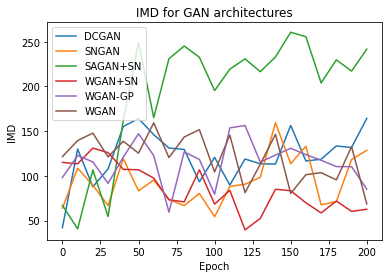

In [ ]:
gan_model_list = ['DCGAN','SNGAN','SAGAN+SN','WGAN+SN','WGAN-GP','WGAN']

fig, ax1 = plt.subplots()
for model in gan_model_list:
  model_dir = os.path.join('/content/drive/My Drive/Thesis_Material',model)
  losses = pd.read_csv(os.path.join(model_dir,'imd_scores.csv'))
  ax1.plot(np.arange(0,201,10),losses['IMD Score'],label = model)
  ax1.legend()
  ax1.set_title('IMD for GAN architectures')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('IMD')
plt.savefig('/content/drive/My Drive/Thesis_Material/imd_gan_plot.png')
